In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shahidshafi/kidney-stone-detection-project

100% 609M/611M [00:37<00:00, 22.0MB/s]
100% 611M/611M [00:37<00:00, 17.2MB/s]


In [ ]:
!unzip -q /content/kidney-stone-detection-project.zip

In [ ]:
!pip install natsort
!pip install MedPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.4 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=2d5c3eab7c112f5e8567c076559b5e7fc94b608b60c59d7c803b04811d32b482
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built MedPy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import skimage
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
# from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.restoration import  denoise_bilateral
from tqdm import tqdm
import natsort
from medpy.filter.smoothing import anisotropic_diffusion

In [ ]:
# !unzip -q /content/kidney-stone-detection-project.zip

In [ ]:
# Get the complete data of kidney stone images
def Get_data(dir, catagories, data):
    for category in catagories:
        path = os.path.join(dir, category)
        class_number = catagories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                new_image = cv2.resize(img_array,(224,224))
                data.append([new_image , class_number])
            except Exception as e:
                pass

data = []
Get_data("/content/CT_SCAN", ["Kidney_stone", "Normal"], data)

In [ ]:
# Categories of Kidney Stone images
catagories = ["Kidney_stone", "Normal"]
print(catagories.index("Kidney_stone"))
print(catagories.index("Normal"))

0
1


(224, 224, 3)


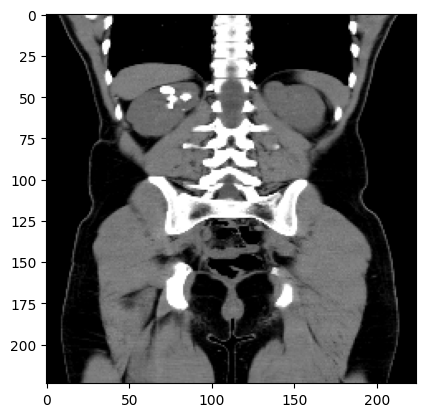

In [ ]:
print(data[143][0].shape)
plt.imshow(data[143][0])
plt.show()

In [ ]:
# Extract Features and Labels from the data
Features = []
Labels = []
for features , labels in data:
    Features.append(features)
    Labels.append(labels)
Features = np.array(Features)
Labels = np.array(Labels)

In [ ]:
Features[143][0]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [104, 104, 104],
       [ 69,  69,  69],
       [  8,   8,   8],
       [ 11,  11,  11],
       [ 42,  42,  42],
       [ 80,  80,  80],
       [108, 108, 108],
       [121, 121, 121],
       [117, 117, 117],
       [120, 120, 120],
       [116, 116, 116],
       [122, 122, 122],
       [121, 121, 121],
       [123, 123, 123],
       [118, 118, 118],
       [118, 118, 118],
       [208, 208, 208],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [230, 230, 230],
       [137, 137, 137],
       [110, 110, 110],
       [106, 106, 106],
       [101, 101, 101],
       [ 86,  86,  86],
       [ 86,  86,  86],
       [ 72,  72,  72],
       [ 80,  80,  80],
       [ 81,  81,  81],
       [ 60,  60,  60],
       [  0,   0

In [ ]:
# Shape of Features and Labels
print(Features.shape)
print(Labels.shape)

(1609, 224, 224, 3)
(1609,)


#Preprocessing

#Filtering

In [ ]:
# Efficient in reducing gaussian image
# Lowers the image resolution
def AnisotropicFilter_wholedataset(noised_dataset, niter, kappa, gamma, option, size):
    anisotropic_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(anisotropic_dataset.shape[0])):
        anisotropic_dataset[i] = anisotropic_diffusion(noised_dataset[i, :, :, :], niter=niter, kappa=kappa, gamma=gamma, option=option).reshape(size, size, 1)
    return anisotropic_dataset

# Apply bilateral filter with d = 15
# sigmaColor = sigmaSpace = 75
# d: Diameter of each pixel neighborhood.
# sigmaColor: Value of sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.
# sigmaSpace: Value of sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.
def cv2bilateralFilter(image, d, sigmaColor, sigmaSpace):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    bilateral = bilateral.astype('uint8')
    return bilateral


In [ ]:
from skimage.morphology import disk
from scipy import ndimage as nd

In [ ]:
def Processed(Processed_images):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10), subplot_kw=dict(xticks=[], yticks=[]), squeeze=False)
    images_to_show = ["Anisotropic_Denoised", "Bilateral_Denoised"]
    for col in range(3):
        for img in Processed_images:
            if img[1] == "Original_Image":
                ax[0][col].imshow(img[0])
                ax[0][col].set_title(img[1])
                ax[0][col].axis('off')
            elif img[1] in images_to_show:
                ax[0][col].imshow(img[0].astype('float64'), cmap="gray")
                ax[0][col].set_title(img[1])
                ax[0][col].axis('off')
                images_to_show.remove(img[1])
                break
    plt.show()


/usr/local/lib/python3.10/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.10/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


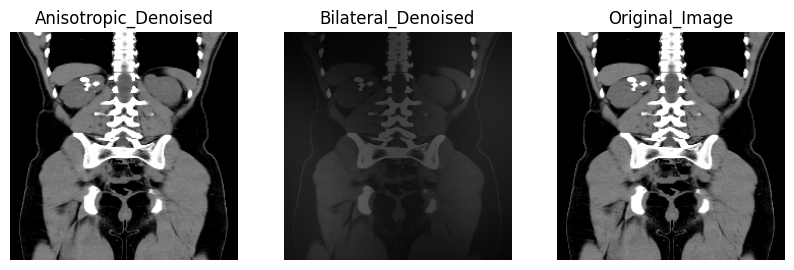

In [ ]:
anisotropic_image = anisotropic_diffusion(Features[143,:,:,:][:,:,0], niter = 50, kappa = 10, gamma = 0.003, option=1)
bilateral_image = denoise_bilateral(Features[143], sigma_spatial = 50, channel_axis = -1)

Processed_images = [[anisotropic_image, "Anisotropic_Denoised"], [bilateral_image, "Bilateral_Denoised"],[Features[143, :, :, :], "Original_Image"]]

Processed(Processed_images)





#Cropping, Thersholding(or masking)

In [ ]:
def crop(image_to_be_cropped):
    height, width = image_to_be_cropped.shape[:2]
    start_row, start_col = int(height * .1), int(width * .1)
    end_row, end_col = int(height * .33), int(width * .78)
    # Crop 10% of the width from both the left and right sides of the image
    start_col += int(width * 0.13)

    cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
    return cropped_image
def threshold(img, thresh1 = 254):
    return ((img > thresh1) * 255).astype('uint8')

In [ ]:
# def crop(image_to_be_cropped):
#     height, width = image_to_be_cropped.shape[:2]
#     start_row, start_col = int(height * .24), int(width * .24)
#     end_row, end_col = int(height * .78), int(width * .78)
# #     start_row, start_col = int(height * .24), int(width * .24)
# #     end_row, end_col = int(height * .42), int(width * .78)
#     cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
#     return cropped_image

# def threshold(img, thresh1 = 254):
#     return ((img > thresh1) * 255).astype('uint8')

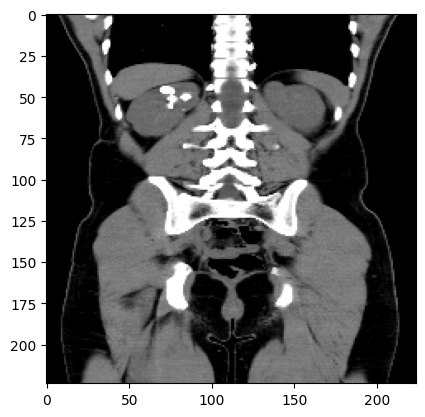

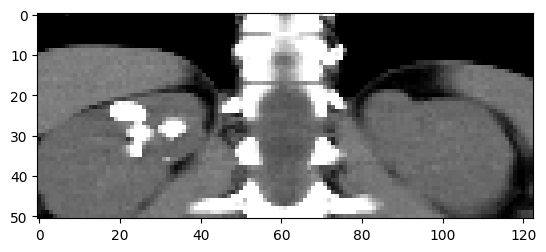

In [ ]:
# Convert BGR image to Gray Scale image
gray_image = cv2.cvtColor(data[143][0], cv2.COLOR_BGR2GRAY)

# expanding dimensions from 128,128 to 128,128,1
gray_image = np.expand_dims(gray_image, axis = -1)
img=crop(gray_image)
plt.imshow(gray_image, cmap = "gray")
plt.show()
plt.imshow(img, cmap = "gray")
plt.show()


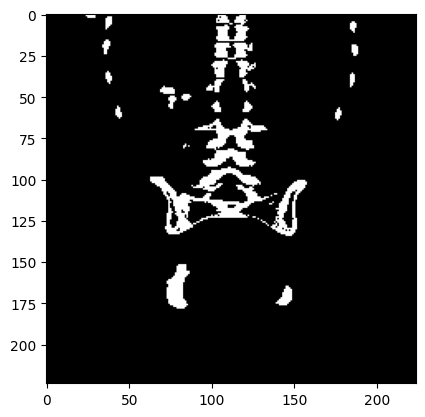

In [ ]:
# Manual Thresholding on the basis of pixel divisions
img1= threshold(gray_image)
plt.imshow(img1, cmap = "gray")
plt.show()

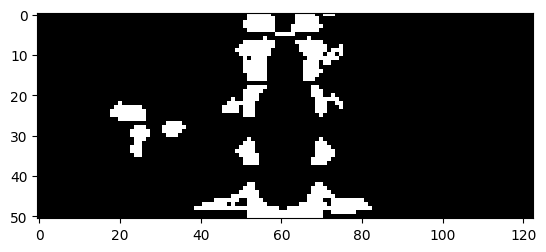

In [ ]:
img2=threshold(img)
plt.imshow(img2, cmap = "gray")
plt.show()

In [ ]:
# Crop all the input images
Cropped_Features = []
for i in range(len(Features)):
    cropped_image = crop(Features[i,:,:,:])
    Cropped_Features.append(cropped_image)
Cropped_Features = np.array(Cropped_Features)

In [ ]:
# On cropped images
bilateral_denoised = []
for i in range(len(Cropped_Features)):
    bilateral = cv2.bilateralFilter(Cropped_Features[i], 15, 75, 75)
    bilateral_denoised.append(bilateral)
bilateral_denoised = np.array(bilateral_denoised)

In [ ]:
anisotropic_denoised = []
for i in range(len(Cropped_Features)):
    # Apply anisotropic filter to each cropped image
    anisotropic =anisotropic_diffusion(Cropped_Features[i])
    anisotropic_denoised.append(anisotropic)
anisotropic_denoised = np.array(anisotropic_denoised)


In [ ]:
thresholded = []
for i in range(len(anisotropic_denoised)):
    temp = threshold(anisotropic_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)


In [ ]:
# # Threshold masking on all the input images

# Original
thresholded = []
for i in range(len(bilateral_denoised)):
    temp = threshold(bilateral_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)

# # Cropped
# thresholded = []
# for i in range(len(Cropped_Features)):
#     temp = threshold(Cropped_Features[i])
#     thresholded.append(temp)
# thresholded = np.array(thresholded)

In [ ]:
print(thresholded.shape)
print(Labels.shape)

(1609, 51, 123, 3)
(1609,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 40% validation + testing
X_train, X_test, Y_train, Y_test = train_test_split(Features, Labels, test_size=0.2, random_state=80, shuffle=True)

# Split validation + testing data into 50% validation and 50% testing
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=80, shuffle=True)

# Converting the list to a numpy array as a requirement for the input in fit function.
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
Y_val=np.array(Y_val)

# Print the sizes of the resulting datasets
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training set size: {len(Y_train)}")
print(f"Validation set size: {len(Y_val)}")
print(f"Testing set size: {len(Y_test)}")


Training set size: 1287
Validation set size: 161
Testing set size: 161
Training set size: 1287
Validation set size: 161
Testing set size: 161


In [ ]:
# # Reshape the labels to have the same number of rows as the embeddings
# Y_train = Y_train.reshape(-1, 1)
# Y_test = Y_test.reshape(-1, 1)
# Y_val=Y_val.reshape(-1, 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)

print(Y_val.shape)

(1287, 224, 224, 3)
(161, 224, 224, 3)
(161, 224, 224, 3)
(1287,)
(161,)
(161,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet101


# Define ResNet101 model
resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last
for layer in resnet101.layers[:-1]:
    layer.trainable = False
# Add custom output layers
x = Flatten()(resnet101.output)
x = Dense(512, activation='relu')(x)
x = Dense(216, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create new model
model = Model(inputs=resnet101.input, outputs=x)
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

METRICS = [BinaryAccuracy(name='accuracy'),
           Precision(name='precision'),
           Recall(name='recall')]


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=METRICS)


# Train the model
history = model.fit(X_train, Y_train,validation_data=(X_val,Y_val),epochs=5, batch_size=32)

Epoch 1/5
41/41 [==============================] - 17s 233ms/step - loss: 4.6594 - accuracy: 0.5633 - precision: 0.5749 - recall: 0.5697 - val_loss: 1.0727 - val_accuracy: 0.6584 - val_precision: 0.5932 - val_recall: 0.9091
Epoch 2/5
41/41 [==============================] - 8s 185ms/step - loss: 0.6171 - accuracy: 0.7754 - precision: 0.7756 - recall: 0.7909 - val_loss: 0.6369 - val_accuracy: 0.7764 - val_precision: 0.6952 - val_recall: 0.9481
Epoch 3/5
41/41 [==============================] - 8s 185ms/step - loss: 0.2088 - accuracy: 0.9239 - precision: 0.9297 - recall: 0.9212 - val_loss: 1.6269 - val_accuracy: 0.6522 - val_precision: 0.5814 - val_recall: 0.9740
Epoch 4/5
41/41 [==============================] - 8s 187ms/step - loss: 0.0931 - accuracy: 0.9697 - precision: 0.9627 - recall: 0.9788 - val_loss: 0.3361 - val_accuracy: 0.8820 - val_precision: 0.8625 - val_recall: 0.8961
Epoch 5/5
41/41 [==============================] - 8s 187ms/step - loss: 0.0176 - accuracy: 0.9977 - precis

In [ ]:
# Evaluate the model on the test set
model.evaluate(X_test, Y_test, verbose=0)


[0.2603098750114441,
 0.9068322777748108,
 0.9042553305625916,
 0.9340659379959106]

In [ ]:
y_pred=model.predict(X_test)

6/6 [==============================] - 4s 151ms/step


In [ ]:
y_pred

In [ ]:
Y_pred=y_pred.round()

In [ ]:
len(Y_test)

161

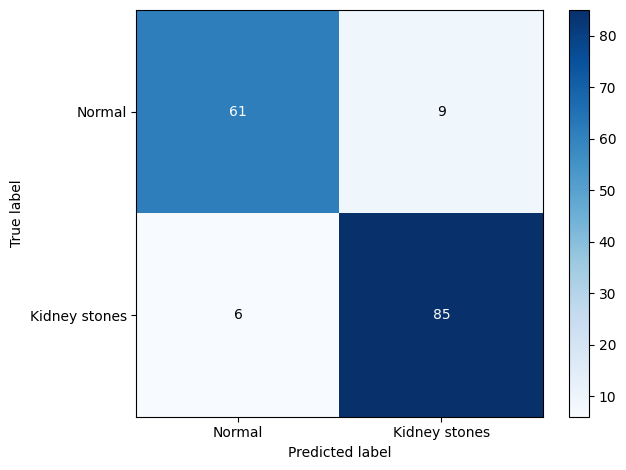

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# define true labels and predicted labels for two classes
y_true = Y_test
y_pred = np.array(Y_pred)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# define class names
classes = ['Normal', 'Kidney stones']

# plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')

# add text annotations to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# load pre-trained VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add custom output layers
x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# create a new model with custom output layers
model = Model(inputs=vgg_model.input, outputs=output)

# freeze VGG19 layers so they're not retrained during training
for layer in vgg_model.layers:
    layer.trainable = False

METRICS=[tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
         tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Recall(name='Recall')]

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
# Train the model
history = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), epochs=5, batch_size=32)

Epoch 1/5
41/41 [==============================] - 14s 209ms/step - loss: 23.2071 - Accuracy: 0.6278 - precision: 0.6349 - Recall: 0.6455 - val_loss: 1.1568 - val_Accuracy: 0.7205 - val_precision: 0.8077 - val_Recall: 0.5455
Epoch 2/5
41/41 [==============================] - 7s 172ms/step - loss: 0.4963 - Accuracy: 0.8664 - precision: 0.8813 - Recall: 0.8545 - val_loss: 1.0740 - val_Accuracy: 0.7516 - val_precision: 0.6637 - val_Recall: 0.9740
Epoch 3/5
41/41 [==============================] - 7s 161ms/step - loss: 0.0933 - Accuracy: 0.9650 - precision: 0.9596 - Recall: 0.9727 - val_loss: 0.6240 - val_Accuracy: 0.8323 - val_precision: 0.9032 - val_Recall: 0.7273
Epoch 4/5
41/41 [==============================] - 6s 158ms/step - loss: 0.0217 - Accuracy: 0.9946 - precision: 0.9954 - Recall: 0.9939 - val_loss: 0.4920 - val_Accuracy: 0.8758 - val_precision: 0.8608 - val_Recall: 0.8831
Epoch 5/5
41/41 [==============================] - 6s 158ms/step - loss: 0.0103 - Accuracy: 0.9984 - preci

In [ ]:
model.evaluate(X_test,Y_test)

6/6 [==============================] - 1s 116ms/step - loss: 0.3384 - Accuracy: 0.8944 - precision: 0.9302 - Recall: 0.8791


[0.33836209774017334,
 0.8944099545478821,
 0.930232584476471,
 0.8791208863258362]

In [ ]:
y_pred=model.predict(X_test)

6/6 [==============================] - 1s 150ms/step


In [ ]:
y_pred

In [ ]:
Y_pred=y_pred.round()

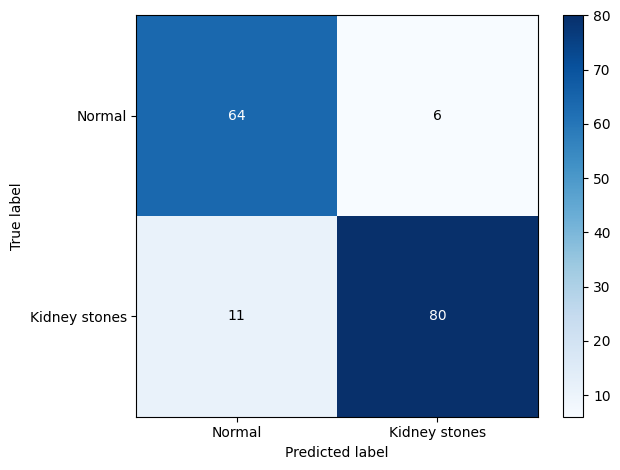

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# define true labels and predicted labels for two classes
y_true = Y_test
y_pred = np.array(Y_pred)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# define class names
classes = ['Normal', 'Kidney stones']

# plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')

# add text annotations to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# load pre-trained DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add custom output layers with regularization
x = Flatten()(densenet_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) # adding a dropout layer with 20% dropout rate
output = Dense(1, activation='sigmoid')(x)

# create a new model with custom output layers
model = Model(inputs=densenet_model.input, outputs=output)

# freeze DenseNet121 layers so they're not retrained during training
for layer in densenet_model.layers:
    layer.trainable = False

METRICS=[tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
         tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Recall(name='Recall')]

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=10, batch_size=32)


Epoch 1/5
41/41 [==============================] - 14s 164ms/step - loss: 46.3616 - Accuracy: 0.5726 - precision: 0.5833 - Recall: 0.5833 - val_loss: 10.5039 - val_Accuracy: 0.6273 - val_precision: 0.8148 - val_Recall: 0.2857
Epoch 2/5
41/41 [==============================] - 4s 106ms/step - loss: 4.4224 - Accuracy: 0.7218 - precision: 0.7247 - Recall: 0.7379 - val_loss: 2.8407 - val_Accuracy: 0.5839 - val_precision: 1.0000 - val_Recall: 0.1299
Epoch 3/5
41/41 [==============================] - 4s 105ms/step - loss: 0.8966 - Accuracy: 0.7218 - precision: 0.7323 - Recall: 0.7212 - val_loss: 0.5382 - val_Accuracy: 0.7329 - val_precision: 0.7073 - val_Recall: 0.7532
Epoch 4/5
41/41 [==============================] - 4s 104ms/step - loss: 0.4727 - Accuracy: 0.7879 - precision: 0.7850 - Recall: 0.8076 - val_loss: 0.5766 - val_Accuracy: 0.6894 - val_precision: 0.8649 - val_Recall: 0.4156
Epoch 5/5
41/41 [==============================] - 4s 103ms/step - loss: 0.4022 - Accuracy: 0.8190 - prec

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# load pre-trained DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add custom output layers
x = Flatten()(densenet_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# create a new model with custom output layers
model = Model(inputs=densenet_model.input, outputs=output)

# freeze DenseNet121 layers so they're not retrained during training
for layer in densenet_model.layers:
    layer.trainable = False

METRICS=[tf.keras.metrics.BinaryAccuracy(name='Accuracy',threshold=0.5),
         tf.keras.metrics.Precision(name='precision'),
         tf.keras.metrics.Recall(name='Recall')]

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=5, batch_size=32)


Epoch 1/5
41/41 [==============================] - 14s 155ms/step - loss: 14.2397 - Accuracy: 0.5649 - precision: 0.5772 - Recall: 0.5667 - val_loss: 1.0493 - val_Accuracy: 0.5963 - val_precision: 0.5448 - val_Recall: 0.9481
Epoch 2/5
41/41 [==============================] - 4s 107ms/step - loss: 0.6601 - Accuracy: 0.7218 - precision: 0.7254 - Recall: 0.7364 - val_loss: 0.7728 - val_Accuracy: 0.7453 - val_precision: 0.6765 - val_Recall: 0.8961
Epoch 3/5
41/41 [==============================] - 4s 106ms/step - loss: 0.4288 - Accuracy: 0.8174 - precision: 0.8167 - Recall: 0.8303 - val_loss: 1.1972 - val_Accuracy: 0.6149 - val_precision: 1.0000 - val_Recall: 0.1948
Epoch 4/5
41/41 [==============================] - 4s 102ms/step - loss: 0.4510 - Accuracy: 0.8190 - precision: 0.8310 - Recall: 0.8121 - val_loss: 1.3561 - val_Accuracy: 0.6335 - val_precision: 0.5682 - val_Recall: 0.9740
Epoch 5/5
41/41 [==============================] - 4s 109ms/step - loss: 0.2292 - Accuracy: 0.9138 - preci

In [ ]:
model.evaluate(X_test,Y_test)

6/6 [==============================] - 1s 82ms/step - loss: 0.3431 - Accuracy: 0.8696 - precision: 0.8723 - Recall: 0.9011


[0.34310469031333923,
 0.8695651888847351,
 0.8723404407501221,
 0.901098906993866]

In [ ]:
y_pred=model.predict(X_test)

6/6 [==============================] - 3s 96ms/step


In [ ]:
Y_pred=y_pred.round()

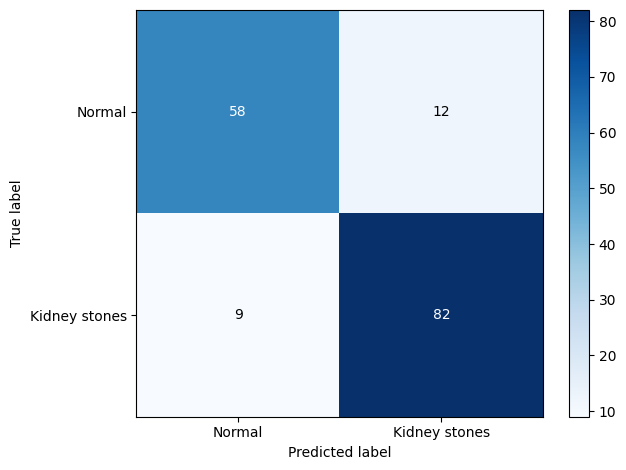

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# define true labels and predicted labels for two classes
y_true = Y_test
y_pred = np.array(Y_pred)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# define class names
classes = ['Normal', 'Kidney stones']

# plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')

# add text annotations to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()